# Shell.ai Hackathon 2025 - Fuel Blend Properties Prediction
# Advanced Solution with Multiple Models

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [104]:
# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

if 'ID' in test_df.columns:
    test_df = test_df.drop(columns=['ID'])

print(f"\nTrain shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (2000, 65)
Test shape: (500, 55)


In [105]:
target_cols = [f'BlendProperty{i}' for i in range(1, 11)]
fraction_cols = [f'Component{i}_fraction' for i in range(1, 6)]

### # OPTIMIZED FEATURE ENGINEERING

In [106]:
def create_optimized_features(df):
    """Streamlined feature engineering focused on physics-based features"""
    df_new = df.copy()

    # 1. LINEAR MIXING (Most important - this IS the physics)
    for prop_idx in range(1, 11):
        df_new[f'Lin_P{prop_idx}'] = sum(
            df[f'Component{i}_fraction'] * df[f'Component{i}_Property{prop_idx}']
            for i in range(1, 6)
        )

    # 2. QUADRATIC MIXING (Captures non-ideal mixing)
    for prop_idx in range(1, 11):
        df_new[f'Quad_P{prop_idx}'] = sum(
            (df[f'Component{i}_fraction'] ** 2) * df[f'Component{i}_Property{prop_idx}']
            for i in range(1, 6)
        )

    # 3. WEIGHTED VARIANCE (Mixing complexity indicator)
    for prop_idx in range(1, 11):
        props = np.array([df[f'Component{i}_Property{prop_idx}'] for i in range(1, 6)]).T
        fracs = np.array([df[f'Component{i}_fraction'] for i in range(1, 6)]).T
        w_mean = np.sum(props * fracs, axis=1)
        w_var = np.sum(fracs * (props - w_mean.reshape(-1, 1))**2, axis=1)
        df_new[f'Var_P{prop_idx}'] = w_var

    # 4. KEY PROPERTY INTERACTIONS (domain knowledge)
    # Property pairs that likely interact
    key_pairs = [(1,2), (1,5), (2,5), (3,7), (5,10)]
    for p1, p2 in key_pairs:
        df_new[f'Int_P{p1}P{p2}'] = sum(
            df[f'Component{i}_fraction'] *
            df[f'Component{i}_Property{p1}'] *
            df[f'Component{i}_Property{p2}']
            for i in range(1, 6)
        )

    # 5. FRACTION FEATURES
    fracs = np.array([df[col] for col in fraction_cols]).T
    df_new['N_Comp'] = (fracs > 0.01).sum(axis=1)
    df_new['MaxFrac'] = fracs.max(axis=1)
    df_new['FracStd'] = fracs.std(axis=1)

    # 6. SQUARED FRACTIONS
    for i in range(1, 6):
        df_new[f'F{i}_sq'] = df[f'Component{i}_fraction'] ** 2

    # 7. TOP FRACTION INTERACTIONS
    for i, j in [(1,2), (1,3), (2,3), (1,4), (2,4)]:
        df_new[f'F{i}F{j}'] = (
            df[f'Component{i}_fraction'] * df[f'Component{j}_fraction']
        )

    return df_new

In [107]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

train_fe = create_optimized_features(train_df)
test_fe = create_optimized_features(test_df)

print(f"Enhanced train shape: {train_fe.shape}")

# Prepare data
X = train_fe.drop(columns=target_cols)
y = train_fe[target_cols]
X_test = test_fe.copy()

common_cols = X.columns.intersection(X_test.columns)
X = X[common_cols]
X_test = X_test[common_cols]

print(f"Feature count: {X.shape[1]}")


FEATURE ENGINEERING
Enhanced train shape: (2000, 113)
Feature count: 103


### MULTI-MODEL ENSEMBLE WITH CV

In [108]:
print("\n" + "="*80)
print("TRAINING ENSEMBLE WITH CROSS-VALIDATION")
print("="*80)

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Storage for predictions
oof_lgb = np.zeros((len(X), len(target_cols)))
oof_xgb = np.zeros((len(X), len(target_cols)))
test_lgb = np.zeros((len(X_test), len(target_cols)))
test_xgb = np.zeros((len(X_test), len(target_cols)))

mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}/{N_FOLDS}")

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    fold_mae = []

    for i, target in enumerate(target_cols):
        # Model 1: LightGBM
        lgb = LGBMRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=6,
            num_leaves=25,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=0.5,
            random_state=42 + fold,
            verbose=-1
        )
        lgb.fit(X_train, y_train[target])
        oof_lgb[val_idx, i] = lgb.predict(X_val)
        test_lgb[:, i] += lgb.predict(X_test) / N_FOLDS

        # Model 2: XGBoost (slightly different)
        xgb = XGBRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=5,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.3,
            reg_lambda=0.3,
            random_state=42 + fold,
            verbosity=0
        )
        xgb.fit(X_train, y_train[target])
        oof_xgb[val_idx, i] = xgb.predict(X_val)
        test_xgb[:, i] += xgb.predict(X_test) / N_FOLDS

        fold_mae.append(mean_absolute_error(y_val[target], oof_lgb[val_idx, i]))

    mae_scores.append(np.mean(fold_mae))
    print(f"  Average MAE: {np.mean(fold_mae):.4f}")


TRAINING ENSEMBLE WITH CROSS-VALIDATION

Fold 1/5
  Average MAE: 0.1256

Fold 2/5
  Average MAE: 0.1219

Fold 3/5
  Average MAE: 0.1244

Fold 4/5
  Average MAE: 0.1267

Fold 5/5
  Average MAE: 0.1250


### LINEAR BASELINE

In [110]:
ridge = Ridge(alpha=5.0)
ridge.fit(X, y)
oof_ridge = ridge.predict(X)
test_ridge = ridge.predict(X_test)

### ENSEMBLE COMBINATION

In [111]:
print("\n" + "="*80)
print("FINAL ENSEMBLE")
print("="*80)

# Test different ensemble weights
weights = [
    (0.50, 0.30, 0.20, "50% LGB, 30% XGB, 20% Ridge"),
    (0.60, 0.25, 0.15, "60% LGB, 25% XGB, 15% Ridge"),
    (0.55, 0.35, 0.10, "55% LGB, 35% XGB, 10% Ridge"),
]

best_mae = float('inf')
best_weights = None
best_predictions = None

for w_lgb, w_xgb, w_ridge, desc in weights:
    oof_ensemble = w_lgb * oof_lgb + w_xgb * oof_xgb + w_ridge * oof_ridge
    mae = mean_absolute_error(y.values, oof_ensemble)
    r2 = r2_score(y.values, oof_ensemble)

    print(f"{desc:40s} | MAE: {mae:.4f} | R2: {r2:.4f}")

    if mae < best_mae:
        best_mae = mae
        best_weights = (w_lgb, w_xgb, w_ridge)
        best_predictions = w_lgb * test_lgb + w_xgb * test_xgb + w_ridge * test_ridge

print(f"\nBest weights: LGB={best_weights[0]:.2f}, XGB={best_weights[1]:.2f}, "
      f"Ridge={best_weights[2]:.2f}")
print(f"Best MAE: {best_mae:.4f}")


FINAL ENSEMBLE
50% LGB, 30% XGB, 20% Ridge              | MAE: 0.1277 | R2: 0.9706
60% LGB, 25% XGB, 15% Ridge              | MAE: 0.1251 | R2: 0.9714
55% LGB, 35% XGB, 10% Ridge              | MAE: 0.1230 | R2: 0.9718

Best weights: LGB=0.55, XGB=0.35, Ridge=0.10
Best MAE: 0.1230


### PER-PROPERTY ANALYSIS

In [112]:
print("\n" + "="*80)
print("PER-PROPERTY PERFORMANCE")
print("="*80)

oof_final = (best_weights[0] * oof_lgb + best_weights[1] * oof_xgb +
             best_weights[2] * oof_ridge)

print("-" * 70)
print(f"{'Property':<20} {'MAE':>10} {'R²':>10} {'Value Range':>20}")
print("-" * 70)

for i, target in enumerate(target_cols):
    mae = mean_absolute_error(y[target], oof_final[:, i])
    r2 = r2_score(y[target], oof_final[:, i])
    val_range = f"[{y[target].min():.2f}, {y[target].max():.2f}]"
    print(f"{target:<20} {mae:>10.4f} {r2:>10.4f} {val_range:>20}")

print("-" * 70)
overall_mae = mean_absolute_error(y.values, oof_final)
overall_r2 = r2_score(y.values, oof_final)
print(f"{'OVERALL':<20} {overall_mae:>10.4f} {overall_r2:>10.4f}")


PER-PROPERTY PERFORMANCE
----------------------------------------------------------------------
Property                    MAE         R²          Value Range
----------------------------------------------------------------------
BlendProperty1           0.1148     0.9772        [-2.55, 2.86]
BlendProperty2           0.1160     0.9773        [-3.08, 2.77]
BlendProperty3           0.1340     0.9685        [-3.04, 1.64]
BlendProperty4           0.1092     0.9792        [-2.84, 3.77]
BlendProperty5           0.0723     0.9854        [-1.73, 3.60]
BlendProperty6           0.0978     0.9833        [-2.81, 3.43]
BlendProperty7           0.1334     0.9682        [-2.99, 3.29]
BlendProperty8           0.1539     0.9606        [-3.62, 3.34]
BlendProperty9           0.1876     0.9398        [-3.29, 3.28]
BlendProperty10          0.1114     0.9784        [-2.48, 2.71]
----------------------------------------------------------------------
OVERALL                  0.1230     0.9718


### SAVE SUBMISSION

In [113]:
submission = pd.DataFrame(best_predictions, columns=target_cols)
submission.to_csv('submission.csv', index=False)

print("\n" + "="*80)
print("SUBMISSION SAVED")
print("="*80)
print("\n[SUCCESS] Predictions saved to 'submission.csv'")
print("\nFirst 10 predictions:")
print(submission.head(10))

print("\nPrediction statistics:")
print(submission.describe())


SUBMISSION SAVED

[SUCCESS] Predictions saved to 'submission.csv'

First 10 predictions:
   BlendProperty1  BlendProperty2  BlendProperty3  BlendProperty4  \
0       -0.039122        0.206676        0.642837        0.581667   
1       -0.676843       -0.535261       -1.056770        0.036060   
2        1.555842        0.897618        1.026921        0.998840   
3       -0.302100        0.409060        0.732427       -0.636197   
4        0.272798       -1.104852        1.068076        0.519470   
5       -1.437839       -1.645793        0.511691       -1.485879   
6        1.157246        0.502873       -0.046434       -0.144837   
7        1.916415        1.126238        0.854077        1.278450   
8        1.169202        1.046242        0.962635        1.561148   
9       -0.955451       -0.828133       -2.014995       -0.627370   

   BlendProperty5  BlendProperty6  BlendProperty7  BlendProperty8  \
0        0.318562        0.682991        0.642628        0.388574   
1       -0.7

### VISUALIZATION


[SUCCESS] Saved: final_predictions.png


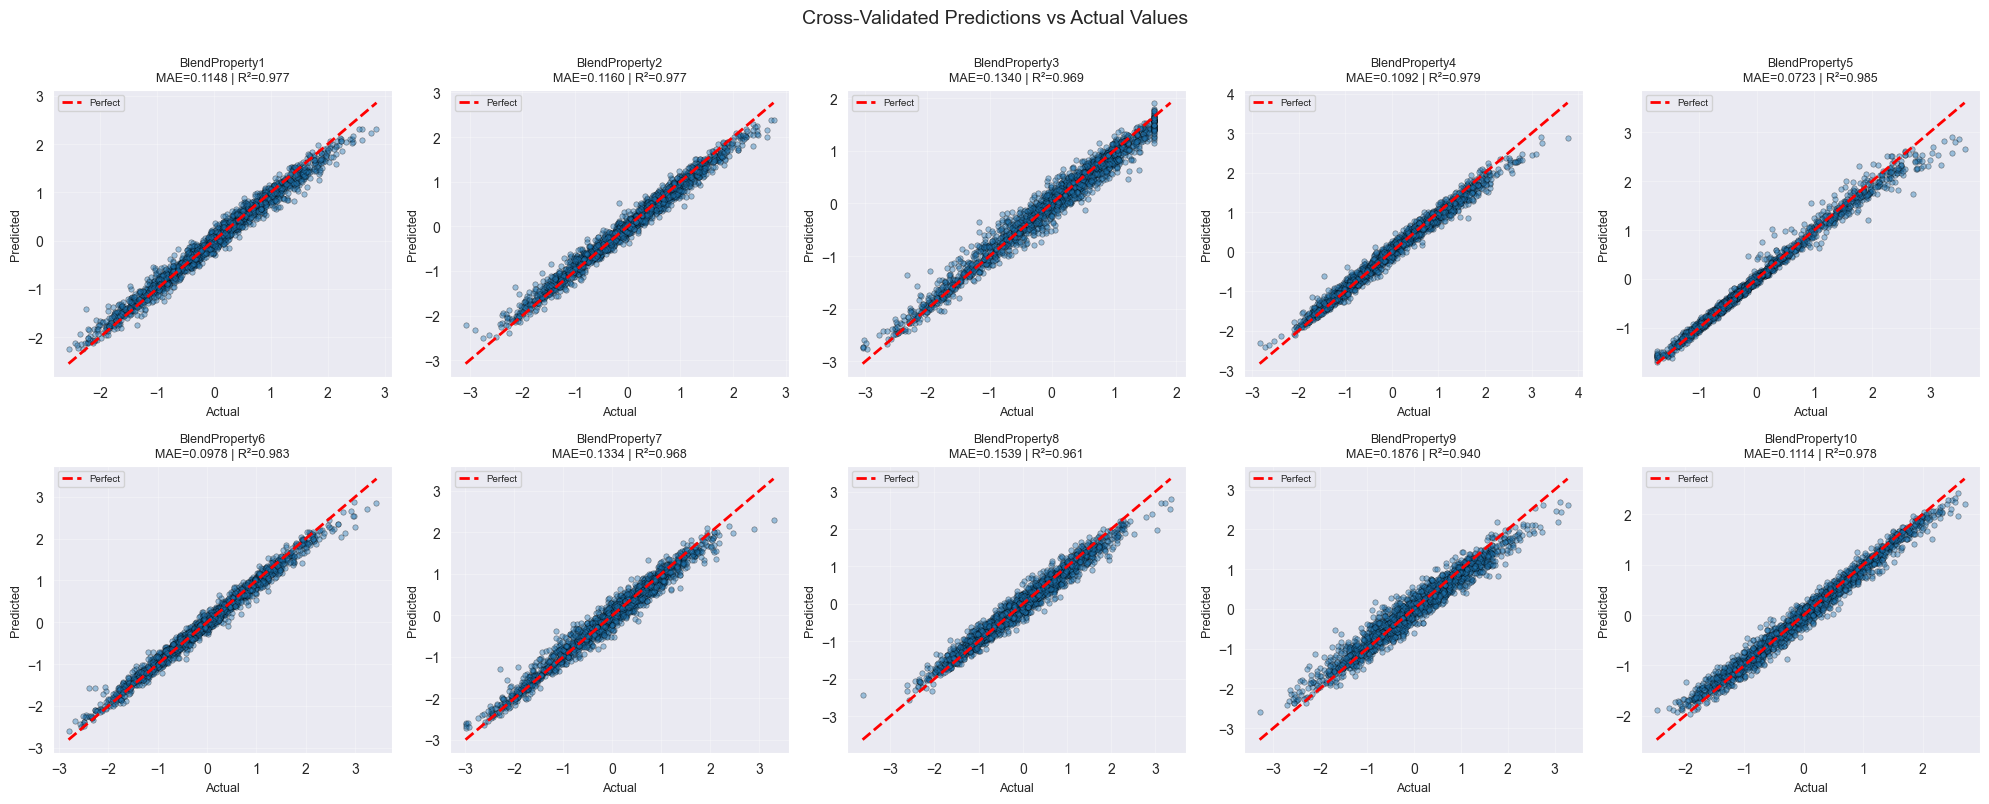

In [114]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, target in enumerate(target_cols):
    ax = axes[i]
    y_true = y[target].values
    y_pred = oof_final[:, i]

    ax.scatter(y_true, y_pred, alpha=0.4, s=15, edgecolors='black', linewidths=0.5)

    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    ax.set_xlabel('Actual', fontsize=9)
    ax.set_ylabel('Predicted', fontsize=9)
    ax.set_title(f'{target}\nMAE={mae:.4f} | R²={r2:.3f}', fontsize=9)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=7)

plt.suptitle('Cross-Validated Predictions vs Actual Values', fontsize=14, y=1.00)
plt.tight_layout()
plt.savefig('final_predictions.png', dpi=300, bbox_inches='tight')
print("\n[SUCCESS] Saved: final_predictions.png")

In [115]:
print("\n" + "="*80)
print("COMPLETE!")
print("="*80)
print(f"\nFinal MAE: {overall_mae:.4f}")
print(f"Final R²:  {overall_r2:.4f}")
print("\nNote: Don't worry about high MAPE - it's inflated by near-zero values.")
print("Focus on MAE and R² which are more reliable metrics for this problem.")


COMPLETE!

Final MAE: 0.1230
Final R²:  0.9718

Note: Don't worry about high MAPE - it's inflated by near-zero values.
Focus on MAE and R² which are more reliable metrics for this problem.
